In [1]:
from plancklens import utils

import camb
from camb import model, initialpower
import numpy as np
import matplotlib.pyplot as plt

import healpy as hp

In [119]:
from os.path import join as opj
import os
from plancklens import utils

cls_path = opj("../", 'data')
#cls_path = opj("/Users/omard/Downloads/", 'giulio')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls.dat'))

cls_original = np.loadtxt(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))

HOME = "../"
tau_dir = opj(HOME, 'data', 'tau_lensing_data')
tau_phi = np.loadtxt(opj(tau_dir, "theory_spectra_optimistic_ptau.txt"))
tau_tau = np.loadtxt(opj(tau_dir, "theory_spectra_optimistic_tautau.txt")) 
tau_tau_pess = np.loadtxt(opj(tau_dir, "theory_spectra_pessimistic_tautau.txt")) 

ell = np.arange(0, len(cls_unl["tt"])+1)
ns = 1
ACB = 7
cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)
cls_alpha[0] = 0


ell = np.arange(0, len(cls_unl["tt"])+1)
ns = 1
ACB = 4
cls_alpha_2 = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)
cls_alpha_2[0] = 0

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_89329/2416094958.py:21: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_89329/2416094958.py:28: RuntimeWarning: divide by zero encountered in divide
  cls_alpha_2 = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)


In [120]:
"""directory = "/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/fonly/simswalpha/"
blm = lambda i: hp.alm2cl(hp.read_alm(directory+f"sim_{i:04}_blm.fits"))
N = 1
cl_bb_tau = np.mean([blm(i) for i in range(N)], axis=0) #to cross-check

directory = "/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/aonly/simswalpha/"
blm = lambda i: hp.alm2cl(hp.read_alm(directory+f"sim_{i:04}_blm.fits"))
N = 1
cl_bb_alpha = np.mean([blm(i) for i in range(N)], axis=0)"""

'directory = "/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/fonly/simswalpha/"\nblm = lambda i: hp.alm2cl(hp.read_alm(directory+f"sim_{i:04}_blm.fits"))\nN = 1\ncl_bb_tau = np.mean([blm(i) for i in range(N)], axis=0) #to cross-check\n\ndirectory = "/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/aonly/simswalpha/"\nblm = lambda i: hp.alm2cl(hp.read_alm(directory+f"sim_{i:04}_blm.fits"))\nN = 1\ncl_bb_alpha = np.mean([blm(i) for i in range(N)], axis=0)'

In [4]:
#https://arxiv.org/pdf/0902.4413, coding Appendix A

from lenspyx.wigners import wigners

lmax_w = 6000

A = wigners.wignerc(tau_tau, cls_unl["ee"], 0, 0, 2, 2, lmax_w)
B = wigners.wignerc(tau_tau, cls_unl["ee"], 0, 0, 2, -2, lmax_w)
cl_bb_screening_th = (A+B)/2


In [121]:
A = wigners.wignerc(tau_tau_pess, cls_unl["ee"], 0, 0, 2, 2, lmax_w)
B = wigners.wignerc(tau_tau_pess, cls_unl["ee"], 0, 0, 2, -2, lmax_w)
cl_bb_screening_th_pesss = (A+B)/2


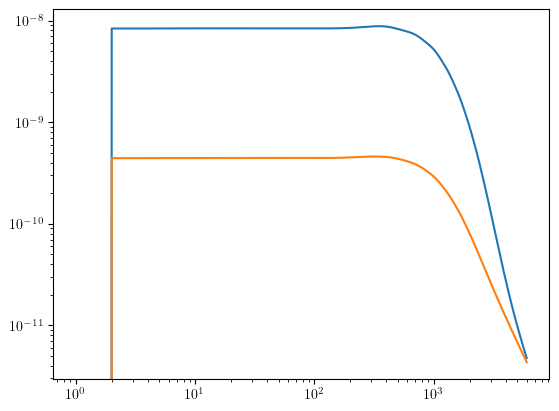

In [122]:
#plt.plot(cl_bb_tau)
plt.loglog(cl_bb_screening_th) #not sure what is happening after 200, but it should be fine for illustration
plt.plot(cl_bb_screening_th_pesss)

In [5]:
#from lenspyx.wigners
def wignerc(cl1: np.ndarray, cl2:np.ndarray, s1: int, t1: int, s2: int, t2: int,
            lmax_out: int = -1):

    lmax1 = len(cl1) - 1
    lmax2 = len(cl2) - 1
    lmax_out = lmax1 + lmax2 if lmax_out < 0 else lmax_out
    lmax_tot = lmax1 + lmax2 + lmax_out
    so = s1 + s2
    to = t1 + t2
    if np.any(cl1) and np.any(cl2):
        npts = (lmax_tot + 2 - lmax_tot % 2) // 2
        if not 'tht wg %s' % npts in wigners.GL_cache.keys():
            wigners.GL_cache['tht wg %s' % npts] = wigners.get_thgwg(npts)
        tht, wg = wigners.GL_cache['tht wg %s' % npts]
        if np.iscomplexobj(cl1):
            xi1 = wigners.wignerpos(np.real(cl1), tht, s1, t1) + 1j * wigners.wignerpos(np.imag(cl1), tht, s1, t1)
            print("Ciao")
        else:
            xi1 = wigners.wignerpos(cl1, tht, s1, t1)
            print("Take exponential!!", t2)
            xi1 = np.exp(4*(-1 if t2 < 0 else 1)*xi1)
        if np.iscomplexobj(cl2):
            xi2 = wigners.wignerpos(np.real(cl2), tht, s2, t2) + 1j * wigners.wignerpos(np.imag(cl2), tht, s2, t2)
        else:
            xi2 = wigners.wignerpos(cl2, tht, s2, t2)
        xi1xi2w = xi1 * xi2 * wg
        if np.iscomplexobj(xi1xi2w):
            ret =wigners.wignercoeff(np.real(xi1xi2w), tht, so, to, lmax_out)
            ret = ret + 1j * wigners.wignercoeff(np.imag(xi1xi2w), tht, so, to, lmax_out)
            return ret
        else:
            return wigners.wignercoeff(xi1xi2w, tht, so, to, lmax_out)
    else:
        return np.zeros(lmax_out + 1, dtype=float)


In [6]:
#https://arxiv.org/pdf/2111.14199 coding page 3

lmax_w = 6000
cls_alpha
thetas, wg = wigners.get_thgwg(lmax_w)
xi_alpha = wigners.wignerpos(cls_alpha, thetas, 0, 0)

np.exp(-4*xi_alpha[0])

0.9999967568781066

In [7]:
A = wignerc(cls_alpha, cls_unl["ee"], 0, 0, 2, 2, lmax_w)
B = wignerc(cls_alpha, cls_unl["ee"], 0, 0, 2, -2, lmax_w)
cl_rotation_th = (A-B)/2

Take exponential!! 2
Take exponential!! -2


In [123]:
A = wignerc(cls_alpha_2, cls_unl["ee"], 0, 0, 2, 2, lmax_w)
B = wignerc(cls_alpha_2, cls_unl["ee"], 0, 0, 2, -2, lmax_w)
cl_rotation_th_2 = (A-B)/2

Take exponential!! 2
Take exponential!! -2


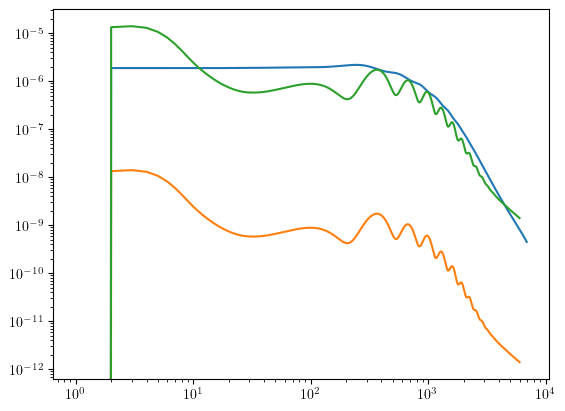

In [124]:
plt.loglog(cls_len["bb"])
plt.plot(cl_rotation_th)
plt.plot(cl_rotation_th_2)
#plt.plot(cl_bb_alpha)

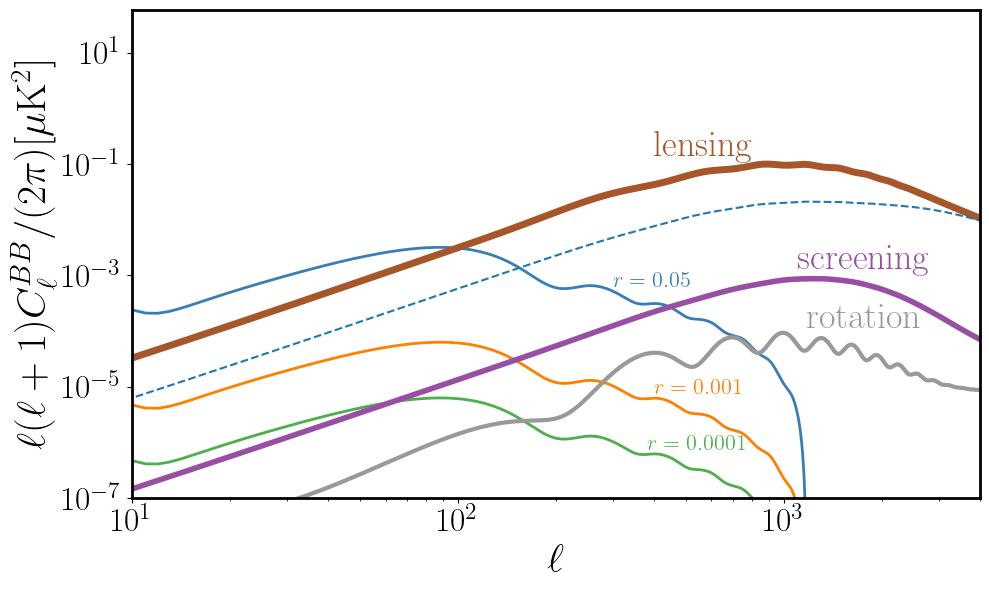

In [78]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Set up the font - using LaTeX-style font
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['text.usetex'] = True

# Your CAMB setup
pars = camb.CAMBparams()
pars.set_cosmology(H0=67, ombh2=0.022445, omch2=0.1212, mnu=0)
lmax = 6000
pars.set_for_lmax(lmax+200, lens_potential_accuracy=2)
pars.max_l_tensor = 6000
pars.WantTensors = True
data = camb.get_results(pars)

# Set up the plot with bold border
plt.figure(figsize=(10, 6))
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Generate curves for different r values
rs = [0.05, 1e-3, 1e-4]
for i, r in enumerate(rs):
    inflation_params = initialpower.InitialPowerLaw()
    inflation_params.set_params(As=2.1265e-09, ns=0.96, r=r)
    data.power_spectra_from_transfer(inflation_params)
    cl = data.get_tensor_cls(lmax, CMB_unit='muK')
    line, = plt.loglog(np.arange(lmax+1), cl[:,2], color=CB_color_cycle[i], lw = 2)
    
    # Add text label on the curve with LaTeX formatting
    idx = 400 if r < 0.05 else 300
    idx = 380 if r == 0.0001 else idx
    x_pos = idx
    y_pos = cl[idx,2] * 1.2
    plt.text(x_pos, y_pos, f'$r={r}$', color=CB_color_cycle[i], fontsize=16)

fontsize = 26

ell = np.arange(len(cls_len["bb"]))
w = ell * (ell + 1) / (2. * np.pi) 
cl = cls_len["bb"]*w
idx = 400
x_pos = idx
y_pos = cl[idx] * 3.2
plt.text(x_pos, y_pos, f'$\mathrm{{lensing}}$', color=CB_color_cycle[4], fontsize=fontsize)
plt.plot(cl, color = CB_color_cycle[4], lw = 5)

ell = np.arange(len(cl_bb_screening_th))
w = ell * (ell + 1) / (2. * np.pi) 
cl = cl_bb_screening_th*w
idx = 1100
x_pos = idx
y_pos = cl[idx] * 1.5
plt.text(x_pos, y_pos, f'$\mathrm{{screening}}$', color=CB_color_cycle[5], fontsize=fontsize)
plt.plot(cl, color =CB_color_cycle[5], lw = 4)

ell = np.arange(len(cl_rotation_th))
w = ell * (ell + 1) / (2. * np.pi) 
cl = cl_rotation_th*w
idx = 1180
x_pos = idx
y_pos = cl[idx] * 2.5
plt.text(x_pos, y_pos, f'$\mathrm{{rotation}}$', color=CB_color_cycle[6], fontsize=fontsize)
plt.plot(cl, color =CB_color_cycle[6], lw = 3)

plt.xlim([2,lmax])
fontsize = 30
plt.ylabel(r'$\ell(\ell+1)C_\ell^{BB}/ (2\pi)[\mu{\rm K}^2]$', fontsize=fontsize)
plt.xlabel(r'$\ell$', fontsize=fontsize)
plt.ylim(1e-7)
#plt.grid(True, which='both', linestyle='--', alpha=0.5)

cbb = np.load("s4data/fid_delcls_10.npy", allow_pickle=True).take(10)["bb"]
ell = np.arange(len(cbb))
w = ell * (ell + 1) / (2. * np.pi) 
cbb *= w
plt.plot(cbb, ls = "--")

plt.plot(bb)

# Make tick labels larger
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(10, 4000)

plt.tick_params(axis='both', which='major', labelsize=24)

plt.tight_layout()
plt.savefig('/Users/omard/Documents/papers/JointCMBiterative/figures/examples/bb_cls.pdf', dpi = 300)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_89329/3764578541.py:3: RuntimeWarning: invalid value encountered in divide
  r2 = 1-ppfinal/ppinitial


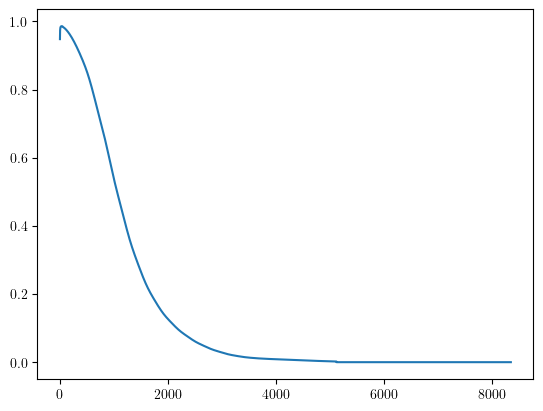

In [60]:
ppfinal = np.load("s4data/fid_delcls_10.npy", allow_pickle=True).take(10)["pp"]
ppinitial = np.load("s4data/fid_delcls_10.npy", allow_pickle=True).take(0)["pp"]
r2 = 1-ppfinal/ppinitial
plt.plot(r2)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_89329/2335054541.py:22: RuntimeWarning: invalid value encountered in divide
  plt.loglog(bb/factor)


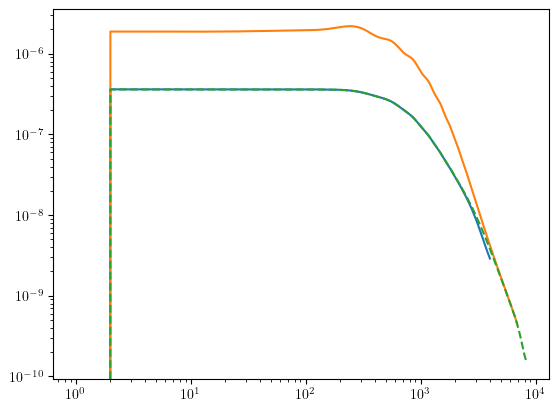

In [114]:
import camb
from camb import correlations

lmax = cls_original.shape[0]
cls = np.zeros((lmax, 4))
w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
    cls[:, i] = cls_original[:, i+1] #

pp = ppfinal[:8349]
l = np.arange(pp.size)
ff = (l * (l + 1))**2. / (2. * np.pi)
dd = pp*ff
lmax = 4000
cls_out = correlations.lensed_cls(cls, dd, lmax = lmax, sampling_factor=4)
bb = cls_out[:, 2]
ell = np.arange(lmax+1)
factor = ell * (ell + 1) / (2. * np.pi)
#bb /= factor

plt.loglog(bb/factor)
plt.plot(cls_len["bb"])
plt.plot(np.load("s4data/fid_delcls_10.npy", allow_pickle=True).take(10)["bb"], ls = "--")

In [67]:
ppfinal.shape, cls_original.shape

((8351,), (8349, 8))